In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3,MobileNetV2, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import argparse


%matplotlib inline

In [4]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)

        img = cv2.imread(PATH)

        img = cv2.resize(img, (RESIZE,RESIZE))

        IMG.append(np.array(img))
    return IMG

In [5]:
#load data
early_blight_norm_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Normal',224))
early_blight_serious_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Serious',224))
late_blight_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LateBlight',224))
healthy_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Healthy',224))
insect_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Insect',224))
lrv_train = np.array(Dataset_loader('/content/drive/MyDrive/potato1/train1/LeafRoll',224))
virus_train =np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Virus',224))

early_blight_norm_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Normal',224))
early_blight_serious_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Serious',224))
late_blight_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LateBlight',224))
healthy_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Healthy',224))
insect_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Insect',224))
lrv_test = np.array(Dataset_loader('/content/drive/MyDrive/potato1/test1/LeafRoll ',224))
virus_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Virus',224))

100%|██████████| 200/200 [00:08<00:00, 22.43it/s]


In [6]:
print(len(lrv_test))

200


In [7]:
# Create labels
early_blight_norm_train_label = np.full(len(early_blight_norm_train),0)
early_blight_serious_train_label = np.full(len(early_blight_serious_train),1)
late_blight_train_label = np.full(len(late_blight_train),2)
virus_train_label = np.full(len(virus_train),3)
insect_train_label = np.full(len(insect_train),4)
lrv_train_label = np.full(len(lrv_train),5)
healthy_train_label = np.full(len(healthy_train),6)

early_blight_norm_test_label = np.full(len(early_blight_norm_test),0)
early_blight_serious_test_label = np.full(len(early_blight_serious_test),1)
late_blight_test_label = np.full(len(late_blight_test),2)
virus_test_label = np.full(len(virus_test),3)
insect_test_label = np.full(len(insect_test),4)
lrv_test_label = np.full(len(lrv_test),5)
healthy_test_label = np.full(len(healthy_test),6)

In [8]:
# Merge data
X_train = np.concatenate((early_blight_norm_train, early_blight_serious_train, late_blight_train, virus_train, insect_train, lrv_train, healthy_train), axis = 0)
Y_train = np.concatenate((early_blight_norm_train_label, early_blight_serious_train_label, late_blight_train_label, virus_train_label, insect_train_label, lrv_train_label, healthy_train_label), axis = 0)
X_test = np.concatenate((early_blight_norm_test, early_blight_serious_test, late_blight_test, virus_test, insect_test, lrv_test,  healthy_test), axis = 0)
Y_test = np.concatenate((early_blight_norm_test_label, early_blight_serious_test_label, late_blight_test_label, virus_test_label, insect_test_label, lrv_test_label, healthy_test_label), axis = 0)

In [9]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [10]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 7)
Y_test = to_categorical(Y_test, num_classes= 7)

In [11]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [12]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images

    )

In [13]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

MobileNetV2     = MobileNetV2(include_top=False, input_shape=input_shape)(inputs)

9406464/9406464 [==============================] - 0s 0us/step


In [14]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(MobileNetV2)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(7, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 concatenate (Concatenate)   (None, 1280)              0         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120  

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/MobileNetV2(7_classes)_old.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [16]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/50
137/136 [==============================] - ETA: -1s - loss: 1.3343 - accuracy: 0.5158

136/136 [==============================] - 480s 3s/step - loss: 1.3343 - accuracy: 0.5158 - val_loss: 2.4416 - val_accuracy: 0.3632 - lr: 1.0000e-04
Epoch 2/50
137/136 [==============================] - ETA: -1s - loss: 0.6432 - accuracy: 0.7483

136/136 [==============================] - 448s 3s/step - loss: 0.6432 - accuracy: 0.7483 - val_loss: 1.4505 - val_accuracy: 0.6331 - lr: 1.0000e-04
Epoch 3/50
137/136 [==============================] - ETA: -1s - loss: 0.4922 - accuracy: 0.8096

136/136 [==============================] - 472s 3s/step - loss: 0.4922 - accuracy: 0.8096 - val_loss: 1.0341 - val_accuracy: 0.7484 - lr: 1.0000e-04
Epoch 4/50
137/136 [==============================] - ETA: -1s - loss: 0.4332 - accuracy: 0.8293

136/136 [==============================] - 451s 3s/step - loss: 0.4332 - accuracy: 0.8293 - val_loss: 0.7693 - val_accuracy: 0.8216 - lr: 1.0000e-04
Epoch 5/50
137/136 [==============================] - ETA: -1s - loss: 0.3838 - accuracy: 0.8439

136/136 [==============================] - 468s 3s/step - loss: 0.3838 - accuracy: 0.8439 - val_loss: 0.3820 - val_accuracy: 0.8856 - lr: 1.0000e-04
Epoch 6/50
137/136 [==============================] - ETA: -1s - loss: 0.3414 - accuracy: 0.8661

136/136 [==============================] - 449s 3s/step - loss: 0.3414 - accuracy: 0.8661 - val_loss: 0.5118 - val_accuracy: 0.8701 - lr: 1.0000e-04
Epoch 7/50
137/136 [==============================] - ETA: -1s - loss: 0.3434 - accuracy: 0.8652

136/136 [==============================] - 446s 3s/step - loss: 0.3434 - accuracy: 0.8652 - val_loss: 0.2596 - val_accuracy: 0.9186 - lr: 1.0000e-04
Epoch 8/50
137/136 [==============================] - ETA: -1s - loss: 0.3020 - accuracy: 0.8757

136/136 [==============================] - 446s 3s/step - loss: 0.3020 - accuracy: 0.8757 - val_loss: 0.2312 - val_accuracy: 0.9140 - lr: 1.0000e-04
Epoch 9/50
137/136 [==============================] - ETA: -1s - loss: 0.2826 - accuracy: 0.8851

136/136 [==============================] - 448s 3s/step - loss: 0.2826 - accuracy: 0.8851 - val_loss: 0.0882 - val_accuracy: 0.9716 - lr: 1.0000e-04
Epoch 10/50
137/136 [==============================] - ETA: -1s - loss: 0.2973 - accuracy: 0.8824

136/136 [==============================] - 477s 3s/step - loss: 0.2973 - accuracy: 0.8824 - val_loss: 0.1071 - val_accuracy: 0.9625 - lr: 1.0000e-04
Epoch 11/50
137/136 [==============================] - ETA: -1s - loss: 0.2741 - accuracy: 0.8920

136/136 [==============================] - 469s 3s/step - loss: 0.2741 - accuracy: 0.8920 - val_loss: 0.0626 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 12/50
137/136 [==============================] - ETA: -1s - loss: 0.2707 - accuracy: 0.8895

136/136 [==============================] - 467s 3s/step - loss: 0.2707 - accuracy: 0.8895 - val_loss: 0.1018 - val_accuracy: 0.9661 - lr: 1.0000e-04
Epoch 13/50
137/136 [==============================] - ETA: -1s - loss: 0.2401 - accuracy: 0.9053

136/136 [==============================] - 451s 3s/step - loss: 0.2401 - accuracy: 0.9053 - val_loss: 0.0755 - val_accuracy: 0.9671 - lr: 1.0000e-04
Epoch 14/50
137/136 [==============================] - ETA: -1s - loss: 0.2538 - accuracy: 0.9007

136/136 [==============================] - 467s 3s/step - loss: 0.2538 - accuracy: 0.9007 - val_loss: 0.0685 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 15/50
137/136 [==============================] - ETA: -1s - loss: 0.2434 - accuracy: 0.9071

136/136 [==============================] - 468s 3s/step - loss: 0.2434 - accuracy: 0.9071 - val_loss: 0.0464 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 16/50
137/136 [==============================] - ETA: -1s - loss: 0.2373 - accuracy: 0.9050

136/136 [==============================] - 447s 3s/step - loss: 0.2373 - accuracy: 0.9050 - val_loss: 0.0772 - val_accuracy: 0.9744 - lr: 1.0000e-04
Epoch 17/50
137/136 [==============================] - ETA: -1s - loss: 0.2307 - accuracy: 0.9030

136/136 [==============================] - 448s 3s/step - loss: 0.2307 - accuracy: 0.9030 - val_loss: 0.1040 - val_accuracy: 0.9634 - lr: 1.0000e-04
Epoch 18/50
137/136 [==============================] - ETA: -1s - loss: 0.2473 - accuracy: 0.9021

136/136 [==============================] - 445s 3s/step - loss: 0.2473 - accuracy: 0.9021 - val_loss: 0.0939 - val_accuracy: 0.9671 - lr: 1.0000e-04
Epoch 19/50
137/136 [==============================] - ETA: -1s - loss: 0.2287 - accuracy: 0.9089

136/136 [==============================] - 445s 3s/step - loss: 0.2287 - accuracy: 0.9089 - val_loss: 0.0828 - val_accuracy: 0.9698 - lr: 1.0000e-04
Epoch 20/50
137/136 [==============================] - ETA: -1s - loss: 0.2212 - accuracy: 0.9119

136/136 [==============================] - 462s 3s/step - loss: 0.2212 - accuracy: 0.9119 - val_loss: 0.1358 - val_accuracy: 0.9506 - lr: 1.0000e-04
Epoch 21/50
137/136 [==============================] - ETA: -1s - loss: 0.2156 - accuracy: 0.9101

136/136 [==============================] - 443s 3s/step - loss: 0.2156 - accuracy: 0.9101 - val_loss: 0.0651 - val_accuracy: 0.9854 - lr: 1.0000e-04
Epoch 22/50
137/136 [==============================] - ETA: -1s - loss: 0.2046 - accuracy: 0.9183

136/136 [==============================] - 447s 3s/step - loss: 0.2046 - accuracy: 0.9183 - val_loss: 0.0638 - val_accuracy: 0.9863 - lr: 1.0000e-04
Epoch 23/50
137/136 [==============================] - ETA: -1s - loss: 0.2103 - accuracy: 0.9146

136/136 [==============================] - 443s 3s/step - loss: 0.2103 - accuracy: 0.9146 - val_loss: 0.0568 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 24/50
137/136 [==============================] - ETA: -1s - loss: 0.2001 - accuracy: 0.9188

136/136 [==============================] - 466s 3s/step - loss: 0.2001 - accuracy: 0.9188 - val_loss: 0.0507 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 25/50
137/136 [==============================] - ETA: -1s - loss: 0.1843 - accuracy: 0.9275

136/136 [==============================] - 466s 3s/step - loss: 0.1843 - accuracy: 0.9275 - val_loss: 0.0971 - val_accuracy: 0.9698 - lr: 1.0000e-04
Epoch 26/50
137/136 [==============================] - ETA: -1s - loss: 0.1831 - accuracy: 0.9295

136/136 [==============================] - 444s 3s/step - loss: 0.1831 - accuracy: 0.9295 - val_loss: 0.1071 - val_accuracy: 0.9661 - lr: 1.0000e-04
Epoch 27/50
137/136 [==============================] - ETA: -1s - loss: 0.1759 - accuracy: 0.9323

136/136 [==============================] - 444s 3s/step - loss: 0.1759 - accuracy: 0.9323 - val_loss: 0.1028 - val_accuracy: 0.9616 - lr: 1.0000e-04
Epoch 28/50
137/136 [==============================] - ETA: -1s - loss: 0.2028 - accuracy: 0.9167

136/136 [==============================] - 442s 3s/step - loss: 0.2028 - accuracy: 0.9167 - val_loss: 0.1133 - val_accuracy: 0.9652 - lr: 1.0000e-04
Epoch 29/50
137/136 [==============================] - ETA: -1s - loss: 0.1769 - accuracy: 0.9323

136/136 [==============================] - 443s 3s/step - loss: 0.1769 - accuracy: 0.9323 - val_loss: 0.0860 - val_accuracy: 0.9707 - lr: 1.0000e-04
Epoch 30/50
137/136 [==============================] - ETA: -1s - loss: 0.1969 - accuracy: 0.9213

136/136 [==============================] - 446s 3s/step - loss: 0.1969 - accuracy: 0.9213 - val_loss: 0.0517 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 31/50
137/136 [==============================] - ETA: -1s - loss: 0.1770 - accuracy: 0.9320

136/136 [==============================] - 445s 3s/step - loss: 0.1770 - accuracy: 0.9320 - val_loss: 0.1698 - val_accuracy: 0.9350 - lr: 1.0000e-04
Epoch 32/50
137/136 [==============================] - ETA: -1s - loss: 0.1785 - accuracy: 0.9307

136/136 [==============================] - 467s 3s/step - loss: 0.1785 - accuracy: 0.9307 - val_loss: 0.0719 - val_accuracy: 0.9707 - lr: 1.0000e-04
Epoch 33/50
137/136 [==============================] - ETA: -1s - loss: 0.1845 - accuracy: 0.9272

136/136 [==============================] - 445s 3s/step - loss: 0.1845 - accuracy: 0.9272 - val_loss: 0.0637 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 34/50
137/136 [==============================] - ETA: -1s - loss: 0.1598 - accuracy: 0.9352

136/136 [==============================] - 447s 3s/step - loss: 0.1598 - accuracy: 0.9352 - val_loss: 0.0620 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 35/50
137/136 [==============================] - ETA: -1s - loss: 0.1764 - accuracy: 0.9311

136/136 [==============================] - 446s 3s/step - loss: 0.1764 - accuracy: 0.9311 - val_loss: 0.0676 - val_accuracy: 0.9753 - lr: 1.0000e-04
Epoch 36/50
137/136 [==============================] - ETA: -1s - loss: 0.1699 - accuracy: 0.9297

136/136 [==============================] - 445s 3s/step - loss: 0.1699 - accuracy: 0.9297 - val_loss: 0.0581 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 37/50
137/136 [==============================] - ETA: -1s - loss: 0.1568 - accuracy: 0.9359

136/136 [==============================] - 443s 3s/step - loss: 0.1568 - accuracy: 0.9359 - val_loss: 0.0598 - val_accuracy: 0.9780 - lr: 1.0000e-04
Epoch 38/50
137/136 [==============================] - ETA: -1s - loss: 0.1707 - accuracy: 0.9357

136/136 [==============================] - 445s 3s/step - loss: 0.1707 - accuracy: 0.9357 - val_loss: 0.0872 - val_accuracy: 0.9680 - lr: 1.0000e-04
Epoch 39/50
137/136 [==============================] - ETA: -1s - loss: 0.1674 - accuracy: 0.9327

136/136 [==============================] - 467s 3s/step - loss: 0.1674 - accuracy: 0.9327 - val_loss: 0.1077 - val_accuracy: 0.9689 - lr: 1.0000e-04
Epoch 40/50
137/136 [==============================] - ETA: -1s - loss: 0.1666 - accuracy: 0.9396

136/136 [==============================] - 444s 3s/step - loss: 0.1666 - accuracy: 0.9396 - val_loss: 0.0680 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 41/50
137/136 [==============================] - ETA: -1s - loss: 0.1601 - accuracy: 0.9368

136/136 [==============================] - 462s 3s/step - loss: 0.1601 - accuracy: 0.9368 - val_loss: 0.0727 - val_accuracy: 0.9771 - lr: 1.0000e-04
Epoch 42/50
137/136 [==============================] - ETA: -1s - loss: 0.1534 - accuracy: 0.9407

136/136 [==============================] - 447s 3s/step - loss: 0.1534 - accuracy: 0.9407 - val_loss: 0.0852 - val_accuracy: 0.9771 - lr: 1.0000e-04
Epoch 43/50
137/136 [==============================] - ETA: -1s - loss: 0.1578 - accuracy: 0.9389

136/136 [==============================] - 445s 3s/step - loss: 0.1578 - accuracy: 0.9389 - val_loss: 0.0469 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 44/50
137/136 [==============================] - ETA: -1s - loss: 0.1607 - accuracy: 0.9320

136/136 [==============================] - 444s 3s/step - loss: 0.1607 - accuracy: 0.9320 - val_loss: 0.0607 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 45/50
137/136 [==============================] - ETA: -1s - loss: 0.1535 - accuracy: 0.9426

136/136 [==============================] - 439s 3s/step - loss: 0.1535 - accuracy: 0.9426 - val_loss: 0.0393 - val_accuracy: 0.9881 - lr: 1.0000e-04
Epoch 46/50
137/136 [==============================] - ETA: -1s - loss: 0.1628 - accuracy: 0.9389

136/136 [==============================] - 443s 3s/step - loss: 0.1628 - accuracy: 0.9389 - val_loss: 0.0899 - val_accuracy: 0.9689 - lr: 1.0000e-04
Epoch 47/50
137/136 [==============================] - ETA: -1s - loss: 0.1631 - accuracy: 0.9339

136/136 [==============================] - 441s 3s/step - loss: 0.1631 - accuracy: 0.9339 - val_loss: 0.0517 - val_accuracy: 0.9826 - lr: 1.0000e-04
Epoch 48/50
137/136 [==============================] - ETA: -1s - loss: 0.1561 - accuracy: 0.9343

136/136 [==============================] - 443s 3s/step - loss: 0.1561 - accuracy: 0.9343 - val_loss: 0.0708 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 49/50
137/136 [==============================] - ETA: -1s - loss: 0.1631 - accuracy: 0.9378

136/136 [==============================] - 442s 3s/step - loss: 0.1631 - accuracy: 0.9378 - val_loss: 0.0633 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 50/50
137/136 [==============================] - ETA: -1s - loss: 0.1363 - accuracy: 0.9487

136/136 [==============================] - 442s 3s/step - loss: 0.1363 - accuracy: 0.9487 - val_loss: 0.0574 - val_accuracy: 0.9835 - lr: 1.0000e-04


47/47 [==============================] - 28s 578ms/step
Confusion matrix, without normalization
[[206   0   0   0   0   0   0]
 [  0 278   0   0   0   0   0]
 [  0   0 200   0   0   0   0]
 [  0   0   0 194   6   0   0]
 [  0   0   0  24 150  32   0]
 [  0   4   0   0   0 196   0]
 [  5   0   0   0   0   0 200]]


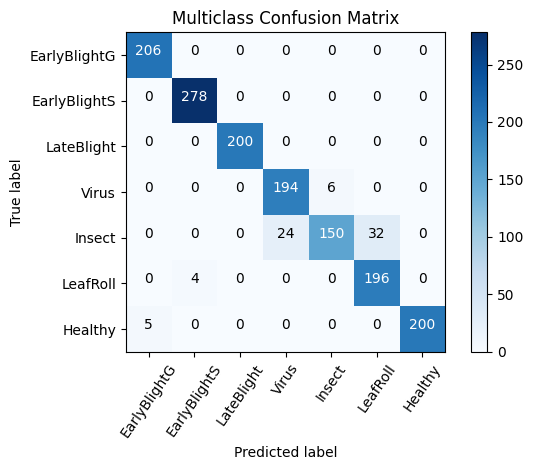

In [17]:
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['EarlyBlightG','EarlyBlightS', 'LateBlight', 'Virus' , 'Insect','LeafRoll', 'Healthy']
plot_confusion_matrix(cm, cm_plot_label, title ='Multiclass Confusion Matrix')

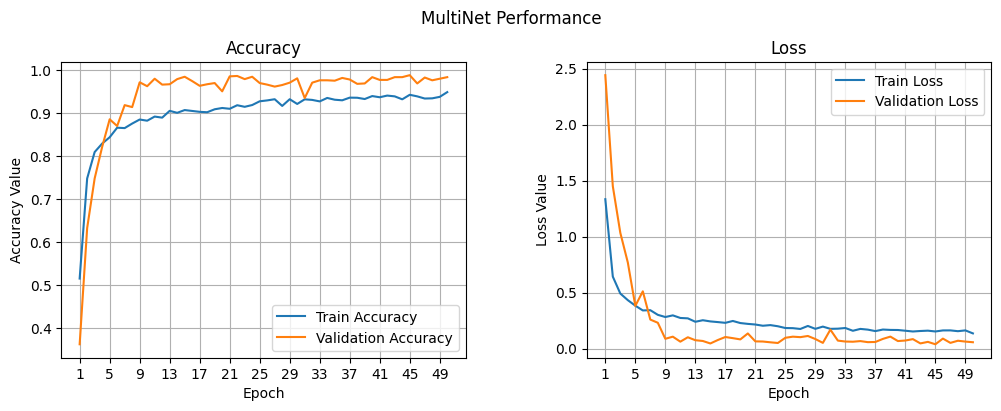

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MultiNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 51, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 51, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [19]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['EarlyBlight General','EarlyBlight Serious', 'LateBlight','Virus' , 'Insect','LeafRoll','Healthy' ]
print(classification_report(y_test, Y_pred, target_names=target_names))

47/47 [==============================] - 29s 608ms/step
Classification Report
                     precision    recall  f1-score   support

EarlyBlight General       0.98      1.00      0.99       206
EarlyBlight Serious       0.99      1.00      0.99       278
         LateBlight       1.00      1.00      1.00       200
              Virus       0.89      0.97      0.93       200
             Insect       0.96      0.73      0.83       206
           LeafRoll       0.86      0.98      0.92       200
            Healthy       1.00      0.98      0.99       205

           accuracy                           0.95      1495
          macro avg       0.95      0.95      0.95      1495
       weighted avg       0.96      0.95      0.95      1495



In [20]:
pred=model.predict(X_test)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error
)

Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

accuray = accuracy_score(Y_pred, y_test)
f1 = f1_score(Y_pred, y_test, average="weighted")
precision = precision_score(Y_pred, y_test, average='weighted')
recall = recall_score(Y_pred, y_test, average='weighted')
mse = mean_squared_error(Y_pred, y_test)
mae = mean_absolute_error(Y_pred, y_test)

print("MobileNetV2")
print("Accuracy:", accuray)
print("F1 Score:", f1)
print("precision:", precision)
print("recall:", recall)
print("MSE:", mse)
print("MAE:", mae)

47/47 [==============================] - 27s 575ms/step
MobileNetV2
Accuracy: 0.9525083612040134
F1 Score: 0.9541437239545483
precision: 0.9609459426282414
recall: 0.9525083612040134
MSE: 0.20468227424749164
MAE: 0.07224080267558529


In [21]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
Y_test=np.argmax(Y_test,1)

47/47 [==============================] - 28s 586ms/step


In [22]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=6)
auc=metrics.auc(fpr, tpr)
auc

0.9775571941765928

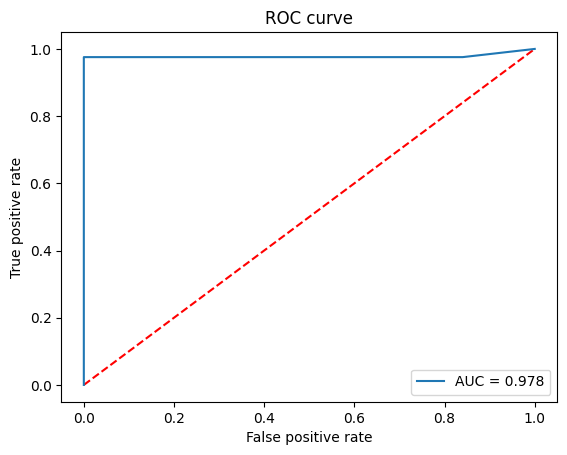

In [23]:
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()
